In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_curve

pd.set_option('display.float_format', '{:.6f}'.format)
np.set_printoptions(suppress=True)

In [2]:
class LogisticRegression(object):
    def __init__(self, X_train, y_train, X_test, y_test, learn_rate=0.001, n_iters=500):
        if len(X_train.shape) == 1:                           #if passing in 1 value (literally a 1d array with one entry we add another 1)
            self.X_train = np.hstack((np.array([1]), X_train))
        else:
            self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))  #Adds bias column in train set
        self.y_train = y_train

        if len(X_test.shape) == 1:
            self.X_test = np.hstack((np.array([1]), X_test))
        else:
            self.X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))   #adds bias column in test set
        self.y_test = y_test

        self.learn_rate = learn_rate
        self.n_iters = n_iters 

        # Initialize model weights
        self.weight = np.zeros((self.X_train.shape[1]))

        self.accuracy_train = []  # To keep track of accuracy on the training data during gradient ascent process
        self.accuracy_test = []  # To keep track of accuracy on the test data during gradient ascent process

        self.log_likelihood_train = []  # To keep track of average log likelihood on the training data during gradient ascent process
        self.log_likelihood_test = []  # To keep track of average log likelihood on the test data during gradient ascent process

    def predict(self, samples, threshold=0.5):
        return self.predict_prob(samples) >= threshold

    def predict_prob(self, samples):
        return 1/(1+np.exp(-np.dot(samples,self.weight)))

    def compute_gradient(self, ):
        #split data because there are two different deratives depending on label
        pos_labels_y = self.y_train[self.y_train == 1]
        pos_labels_x = self.X_train[self.y_train == 1]
        neg_labels_y = self.y_train[self.y_train == 0]
        neg_labels_x = self.X_train[self.y_train == 0]

        error_partials = []
        for i in range(len(self.weight)):
            pos_deriv = 1/(1+np.exp(-np.dot(pos_labels_x,self.weight))) * np.exp(-np.dot(pos_labels_x,self.weight)) * pos_labels_x[:,i]
            neg_deriv = (1/(1+np.exp(-np.dot(neg_labels_x, self.weight))) * np.exp(-np.dot(neg_labels_x, self.weight)) * neg_labels_x[:,i]) - neg_labels_x[:,i]
            
            comput = np.concatenate([pos_deriv,neg_deriv], axis = 0)
            error_partials.append(np.mean(comput))
            
        return np.array([error_partials]).transpose()
        
    def gradient_ascent(self, ):
        pos_labels_x_train = self.X_train[self.y_train == 1]
        neg_labels_x_train = self.X_train[self.y_train == 0]

        pos_labels_x_test = self.X_test[self.y_test == 1]
        neg_labels_x_test = self.X_test[self.y_test == 0]
        #compute average log likelihood with current weights for test and train
        for i in range(self.n_iters):
            print(f"iteration number: {i}")
            #With train set
            self.weight = (self.weight + self.learn_rate * self.compute_gradient().transpose()).flatten()
            probas_pos = 1/(1+np.exp(-np.dot(pos_labels_x_train,self.weight)))
            probas_neg = 1 - 1/(1+np.exp(-np.dot(neg_labels_x_train, self.weight)))
            likelihood = np.mean(np.log(np.concatenate([probas_pos,probas_neg])))
            self.log_likelihood_train.append(likelihood)
        #computing accuracy this is working because accuracy is succesfully increasing as per iteration of gradient ascent
            self.accuracy_train.append(np.sum(self.predict(self.X_train) == self.y_train)/len(self.y_train))

        #With Test set
            probas_pos_test = 1/(1+np.exp(-np.dot(pos_labels_x_test,self.weight)))
            probas_neg_test = 1 - 1/(1+np.exp(-np.dot(neg_labels_x_test, self.weight)))
            likelihood = np.mean(np.log(np.concatenate([probas_pos_test,probas_neg_test])))
            self.log_likelihood_test.append(likelihood)
        #computing accuracy this is working because accuracy is succesfully increasing as per iteration of gradient ascent
            self.accuracy_test.append(np.sum(self.predict(self.X_test) == self.y_test)/len(self.y_test))
        print("Gradient Ascent Sucessfully finished!")
        return
        

In [3]:
def preprocess_data(X_train, X_test):
    
    ohe = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore').set_output(transform = 'pandas')
    ss = StandardScaler().set_output(transform = 'pandas')
    combined_data = pd.concat([X_train, X_test], axis=0) #this will be for OHE so I don't have dimensional errors later
    
    categories_feat = combined_data.select_dtypes(include = 'object').columns
    numerical_feat = ~np.isin(combined_data.columns,categories_feat)
    
    #categorical encoding
    cat_df = combined_data[categories_feat]
    transformed_cat = ohe.fit_transform(cat_df)
    
    #numerical encoding
    num_df = combined_data.loc[:, numerical_feat]
    print(num_df.columns)
    transformed_num = ss.fit_transform(num_df)

    #full frame
    full_trans = pd.concat([transformed_num, transformed_cat],axis = 1)

    train_orig = full_trans.iloc[:len(X_train),:]
    test_orig = full_trans.iloc[len(X_train):,:]
        
    return (train_orig,test_orig)

In [4]:
def plot_log_likelihood_performance(log_likelihood_train, log_likelihood_test):
    x = np.linspace(1,len(log_likelihood_train), len(log_likelihood_train))
    plt.plot(x, log_likelihood_train, label = "Training Data")
    plt.plot(x, log_likelihood_test, label = "Testing Data")
    plt.legend()
    plt.xlabel("Iterations Of Gradient Descent")
    plt.ylabel("Average Log Likelihood")
    plt.title(f"Train Performance Vs Test Performance (Average Log Likelihood) | Learn Rate: {learner.learn_rate}")

In [5]:
def plot_accuracy_performance(accuracy_train, accuracy_test):
    x = np.linspace(1,len(accuracy_train), len(accuracy_train))
    plt.plot(x,accuracy_train, label = "Training Data")
    plt.plot(x,accuracy_test, label = "Testing Data")
    plt.title(f"Accuracy For Train Data and Test Data | Learn Rate: {learner.learn_rate}")
    plt.xlabel("Gradient Descent Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')

In [6]:
def plot_roc(X_train, y_train, X_test , y_test, learner):

    #get probabilities 
    probas_test = learner.predict_prob(X_test)
    probas_train = learner.predict_prob(X_train)
                                       
    #Use scikit (na because it unpacks into three objects one not necessary)
    fpr_test, tpr_test, na = roc_curve(y_test, probas_test)
    fpr_train,tpr_train,na_train = roc_curve(y_train, probas_train)
                                        
    # Calculate the AUC (Area Under the Curve)
    roc_auc_test = auc(fpr_test, tpr_test)
    roc_auc_train = auc(fpr_train, tpr_train)

    #plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'ROC curve Train Set (Area Under Curve = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'ROC curve Test Set (Area Under Curve = {roc_auc_test:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve | Learn Rate: {learner.learn_rate}")
    plt.legend(loc='lower right')

In [7]:
# Load data
train_data = pd.read_csv('cleaned_train_data.csv')
test_data = pd.read_csv('cleaned_test_data.csv')
X_train = train_data.drop(['income'], axis=1, inplace=False)
y_train = train_data['income']
X_test = test_data.drop(['income'], axis=1, inplace=False)
y_test = test_data['income']

In [8]:
# Preprocessing data
processed_X_train, processed_X_test = preprocess_data(X_train, X_test)

Index(['age', 'capital.gain', 'capital.loss', 'hours.per.week'], dtype='object')


In [9]:
processed_X_train

,age,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0.690484,-0.230725,-0.216660,-0.035429,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,1.130359,-0.230725,3.932697,0.774468,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.323921,-0.230725,-0.216660,-0.035429,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
3,-0.482518,-0.230725,-0.216660,-0.440378,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.323921,-0.230725,-0.216660,0.774468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,-0.335892,-0.230725,-0.216660,-0.440378,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
26045,-1.142331,-0.230725,-0.216660,-2.465122,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
26046,0.397233,-0.230725,-0.216660,1.179417,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
26047,-1.142331,-0.230725,-0.216660,-0.035429,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [10]:
# Run gradient ascent with Logistic Regression
learner = LogisticRegression(processed_X_train, y_train.values, processed_X_test, y_test.values,
                                 n_iters=100, learn_rate=0.75)
learner.gradient_ascent()


iteration number: 0
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
iteration number: 9
iteration number: 10
iteration number: 11
iteration number: 12
iteration number: 13
iteration number: 14
iteration number: 15
iteration number: 16
iteration number: 17
iteration number: 18
iteration number: 19
iteration number: 20
iteration number: 21
iteration number: 22
iteration number: 23
iteration number: 24
iteration number: 25
iteration number: 26
iteration number: 27
iteration number: 28
iteration number: 29
iteration number: 30
iteration number: 31
iteration number: 32
iteration number: 33
iteration number: 34
iteration number: 35
iteration number: 36
iteration number: 37
iteration number: 38
iteration number: 39
iteration number: 40
iteration number: 41
iteration number: 42
iteration number: 43
iteration number: 44
iteration number: 45
iteration number: 46
iteration number: 47
it

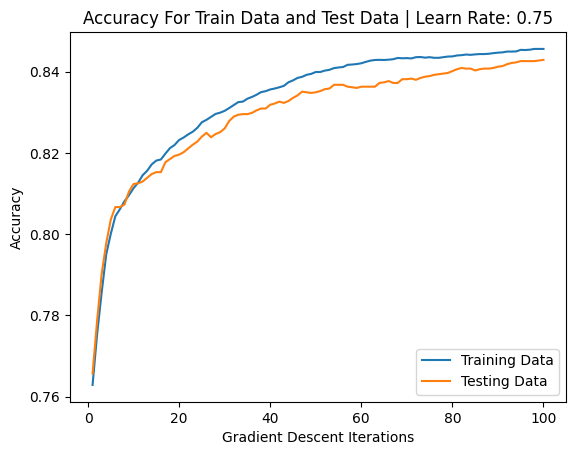

In [11]:
# Plot prediction accuracy during training process
plot_accuracy_performance(learner.accuracy_train, learner.accuracy_test)

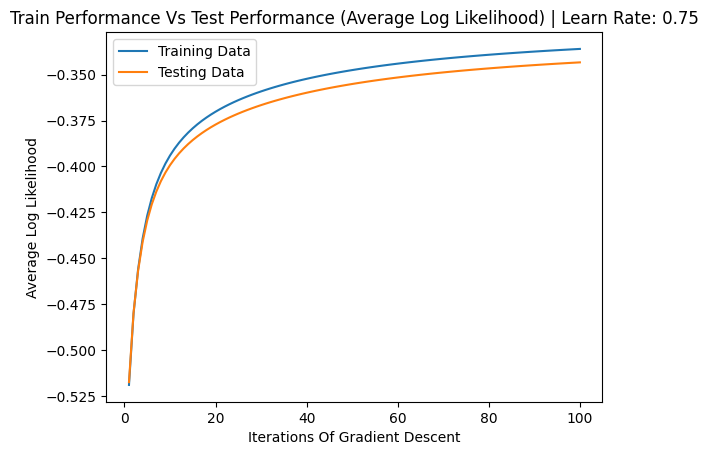

In [12]:
# Plot Log Likelihood values during training process
plot_log_likelihood_performance(learner.log_likelihood_train, learner.log_likelihood_test)

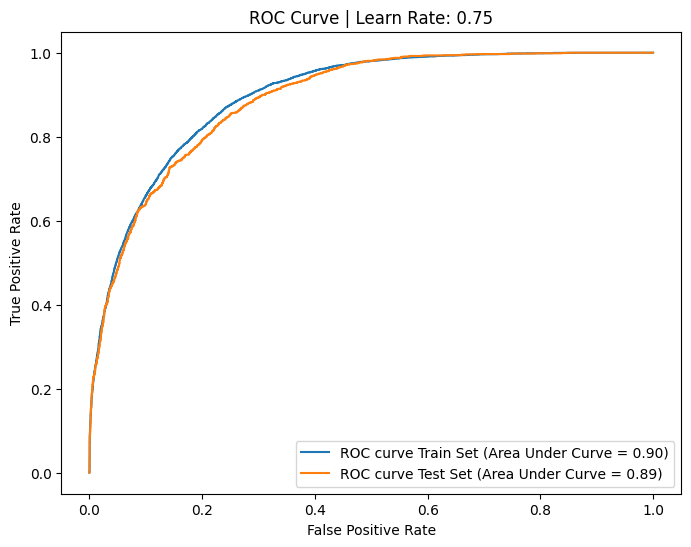

In [13]:
# Plot ROC curves
plot_roc(learner.X_train, y_train, learner.X_test, y_test, learner)
